In [3]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 41 kB 94 kB/s  eta 0:00:011
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30536 sha256=e2d68507f80008dca0cae04add42b6a669b47017139139ccaf288d9d282f87ab
  Stored in directory: /home/docando/.cache/pip/wheels/19/18/97/0d58cab1b354f98e6b1b3791e9b2dc14ce537d63daec0d4924
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19471 sha256=d5971562ae54bb7bce519e5843208b9ff62c9f9e00079f3190868606753b0b68
  Stored in directory: /home/docando/.cache/pip/wheels/9d/c6/c5/a3f4a618640f461130f47e76703156c13a39cc3b96b5f4f439
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7910 sha256=9ee6e70dd84141c762e7c8580b5b4b5850fa6a4b2ccfff642e0d941902542ce7
  Stored in directory: /home/docando/.cache/pip/wheels/48/77/b1/d0b01d524d972512852e1fc23b197ad9d3d1685e349b8cabb6
Successfully built bert-for-tf2 params-flow py-params


In [36]:
# 01. 라이브러리 불러오기
import os, json, glob, sys, numpy as np
import pandas as pd
import re
import nltk 
import matplotlib.pyplot as plt

from keras.utils import np_utils
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert

## Import & preprocess the data

### 함수 정의

In [8]:
def load_data():
    train = pd.read_csv("data/train_final.csv")
    eval = pd.read_csv("data/eval_final_open.csv")
    train_X = train['Sentence'] # 본문 내용을 기준으로 분류하기
    train_Y = train['Category']
    eval_X = eval['Sentence']
    return train_X, train_Y, eval_X

In [6]:
def preprocessing(documents):
    ## 01. 영어만 남기기
    documents = documents.str.replace("[^a-zA-Z ]","")
    
    ## 02. 불용어 제거, 토큰화
    clean_documents = []
    for sentence in documents:
        # tokens = word_tokenize(sentence) # 토큰화
        # tokens = [word for word in tokens if word not in stopwords.words('english')] # 불용어 제거
        # clean_texts = " ".join(tokens)
        clean_texts = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # 단일 캐릭터 제거
        clean_texts = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', clean_texts) # 특수문자, 임티 제거
        clean_texts = re.sub(' +', ' ', clean_texts) # 다중 공백 제거
        clean_documents.append(clean_texts)
    return clean_documents 

In [25]:
from sklearn.preprocessing import LabelEncoder

def labeling(train_y):
    datasets = np.array(train_y).tolist()
  
    # 데이터 라벨링
    le = LabelEncoder()
    le.fit(datasets)
    print(le.classes_) # 확인해보기

    nb_classes = len(le.classes_)
    print('class 개수 : ', nb_classes)
    transform_data = le.transform(datasets)

    # 라벨링한 y 데이터를 원 핫 벡터로 바꿈
    transform_data = np_utils.to_categorical(transform_data, nb_classes)
    print(transform_data)

    # 다시 학습, 테스트 데이터로 분할
    y_train = transform_data

    return y_train, nb_classes

### 함수 적용

In [28]:
# 데이터 로드
train_x, train_y, test_x = load_data()

# 데이터 전처리
train_x, test_x = preprocessing(train_x), preprocessing(test_x)

In [29]:
# 임시 저장

pd.DataFrame(train_x).to_csv('data/train_x.csv')
pd.DataFrame(test_x).to_csv('data/test_x.csv')

In [30]:
# 임시 불러오기
train_x, test_x = pd.read_csv('data/train_x.csv'), pd.read_csv('data/test_x.csv')

In [31]:
train_y

0        3
1        2
2        4
3        1
4        2
        ..
11539    3
11540    1
11541    4
11542    4
11543    4
Name: Category, Length: 11544, dtype: int64

In [32]:
train_x = train_x['0']
test_x = test_x['0']
print(train_x)
print(test_x)

0        LRB The film RRB tackles the topic of relation...
1                       Lavishly exhilaratingly tasteless 
2                            It is also beautifully acted 
3        But like Silence it a movie that gets under yo...
4        It been made with an innocent yet fervid convi...
                               ...                        
11539    Although Frailty fits into classic genre in it...
11540                    Mediocre fable from Burkina Faso 
11541    Like all great films about life you never knew...
11542    Those who are nt put off by the film austerity...
11543    An ambitious movie that like Shiner organizing...
Name: 0, Length: 11544, dtype: object
0       Altogether this is successful as film while at...
1       Not cheap slasher flick as the subject matter ...
2        plays like somebody spliced random moments of...
3       While the Resident Evil games may have set new...
4       Too lazy to take advantage of its semihumorous...
                       

In [33]:
train_x = train_x.to_list()
test_x = test_x.to_list()
print(train_x)
print(test_x)

['LRB The film RRB tackles the topic of relationships in such straightforward emotionally honest manner that by the end it impossible to ascertain whether the film is at its core deeply pessimistic or quietly hopeful ', 'Lavishly exhilaratingly tasteless ', 'It is also beautifully acted ', 'But like Silence it a movie that gets under your skin ', 'It been made with an innocent yet fervid conviction that our Hollywood has all but lost ', 'Director David Jacobson gives Dahmer consideration that the murderer never game his victims ', 'Overall Cletis Tout is winning comedy that excites the imagination and tickles the funny bone ', 'The movie is too impressed with its own solemn insights to work up much entertainment value ', ' LRB Hopkins RRB does nt so much phone in his performance as fax it ', 'Delirious fun ', 'Too bland and fustily tasteful to be truly prurient ', 'Ozpetek effort has the scope and shape of an especially wellexecuted television movie ', 'As the Mediterranean sparkles Sw

In [91]:
# 카테고리 라벨링
y_train, nb_classes = labeling(train_y)
y_train = y_train.tolist()

[0 1 2 3 4]
class 개수 :  5
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


## Tokenizing

### BERT Tokenizer

In [38]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'.
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1: 180.00MB
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1: 360.00MB
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1, Total size: 423.26MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'.


In [44]:
# 잘 되는지 확인
print(tokenizer.tokenize("That's mine, and this is your's"))

print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("That's mine, and this is your's")))

['that', "'", 's', 'mine', ',', 'and', 'this', 'is', 'your', "'", 's']
[2008, 1005, 1055, 3067, 1010, 1998, 2023, 2003, 2115, 1005, 1055]


In [45]:
# single 리뷰를 받아서 토큰화된 단어의 아이디를 반환하는 함수

def tokenizing(sentence):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence))

tokenized_data = [tokenizing(l) for l in train_x]

리뷰 최대 길이 : 255
리뷰 최소 길이 : 2
리뷰 평균 길이 : 96.187110


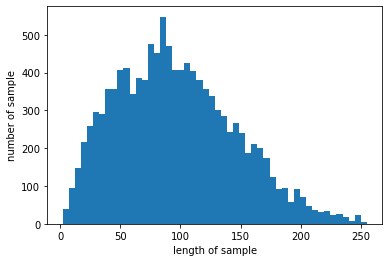

In [50]:
# 토큰화 위한 단어 길이 확인 - train_x

max_len = max(len(l) for l in train_x)
print('리뷰 최대 길이 : %d' % max_len)
print('리뷰 최소 길이 : %d' % min(len(l) for l in train_x))
print('리뷰 평균 길이 : %f' % (sum(map(len, train_x))/len(train_x)))
plt.hist([len(s) for s in train_x], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

### Padding 적용

In [104]:
data_pairs = list(zip(tokenized_data, y_train))
processed_datase = tf.data.Dataset.from_generator(lambda: data_pairs, output_types=(tf.int32, tf.int32))

In [105]:
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), (None,)))

In [106]:
next(iter(batched_dataset))

(<tf.Tensor: shape=(32, 42), dtype=int32, numpy=
 array([[ 1048, 15185,  1996, ...,  2030,  5168, 17772],
        [22689,  2135,  4654, ...,     0,     0,     0],
        [ 2009,  2003,  2036, ...,     0,     0,     0],
        ...,
        [ 1037,  2444, 20357, ...,     0,     0,     0],
        [ 2045,  2053,  3160, ...,     0,     0,     0],
        [ 1048, 15185, 25269, ...,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: shape=(32, 5), dtype=int32, numpy=
 array([[0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
       

In [ ]:
TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE) # 전체 
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)